# To Figure Out:  
How to get transforms working without requirings all images from the start  
Figure out GAN Loss and cycle loss  
Will need to edit training loop using iter and next so that I can use one img from each dataset concurrently  


#Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from google.colab import files, drive
from sklearn.model_selection import KFold
import csv
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Get list of names for monet painting files
mon_dir = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Monet"
mon_ann = os.listdir(mon_dir)

# Get list of names for scenery image files
scene_dir = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Photos"
scene_ann = os.listdir(scene_dir)

In [5]:
print(f"Number of Monet Images: [{len(mon_ann)}] " f"Amount of scenery photos: [{len(scene_ann)}]")

Number of Monet Images: [1193] Amount of scenery photos: [7041]


In [6]:
# Create the dataset:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, directory, annotations, aug=False):
    self.indexed_dataset = [sample for sample in annotations]
    self.dir = directory
    if self.dir[len(self.dir) - 1] != "/":
      self.dir += "/" # Ensures correct spelling
    self.aug = aug
    self.aug_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                             transforms.RandomVerticalFlip(),
                                             transforms.RandomRotation(90),
                                             transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2, hue=(-0.1,0.1))])

  def get_image_tensor(self, idx):
    to_tensor = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    img = Image.open(self.dir + self.indexed_dataset[idx])
    if (img.mode != "RGB"):
      img = img.convert('RGB')
    img = img.resize((64,64), Image.BOX)
    # Returns transformed image
    return to_tensor(img)

  def get_augmented_images(self, img):
    final_img_list = [img]
    for i in range(3):
      final_img_list.append(self.aug_transform(img))
    return final_img_list

  def __len__(self):
    return len(self.indexed_dataset)

  def __getitem__(self, idx): 
    img = self.get_image_tensor(idx)
    if self.aug == False: 
      return img # No augmentation so return only the 1 image
    else:
      # Return image + 3 other transformed images to improve generalization
      return self.get_augmented_images(img)

# ------------------------
# Define dataset:
# ------------------------

# Monet Paintings:
monet_dataset = MyDataset(mon_dir, mon_ann, aug=True)

# Scene Images:
scene_dataset = MyDataset(scene_dir, scene_ann, aug=False)

#W-GANS

In [7]:
# As recommended in my paper, I built my resnet block loosely on the implementation from: https://github.com/jcjohnson/fast-neural-style
class ResNetBlock(nn.Module):
  def __init__(self, in_ch, out_ch, bias=False, dropout=False):
    super(ResNetBlock, self).__init__()
    assert in_ch == out_ch, "Resnet block needs equal in_ch and out_ch"

    convolution_head = []
    convolution_head += [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride =1, bias=bias),
                         nn.BatchNorm2d(out_ch),
                         nn.ReLU(True)]
    if dropout == True:
      convolution_head += [nn.Dropout(0.5)]
    convolution_head += [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride =1, bias=bias),
                         nn.BatchNorm2d(out_ch)]
    self.conv_head = nn.Sequential(*convolution_head)

  def forward(self, x):
    out = x + self.conv_head(x)
    return out


Latent will be of size 64
changed resnet kernel_size=3, padding=1, stride=0 to kernel_size=3, padding=2, stride =1  
changed first conv2d to have output_padding of 1 to keep even numbers  

In [8]:
# W-GAN Network based on U-NET architecture which employs the use of skip connections through ResNet layers
# Bias is kept as false due to limited training data
class Generator(nn.Module):
  def __init__(self, num_resnet=3, bias=False, dropout=False):
    super(Generator, self).__init__()
    base_num_filters = 64
    model = []
    # Image to latent representation:
    model += [nn.ReflectionPad2d(3), # Ensures no change to data size
              nn.Conv2d(3, base_num_filters, kernel_size=7, padding=0, bias=bias),
              nn.BatchNorm2d(base_num_filters, eps=1e-5), # Ensure eps is set since we will use batch_size=1
              nn.LeakyReLU(0.2, False)]

    # Downsampling layers (from 64->128->256->512)
    # Could try normal ReLU instead of LeakyReLU
    num_downsampling = 3
    for i in range(num_downsampling):
      filter_mult = 2 ** i
      model += [nn.Conv2d(base_num_filters * filter_mult, base_num_filters * filter_mult * 2, kernel_size=3, stride=2, padding=1, bias=bias),
                nn.BatchNorm2d(base_num_filters * filter_mult * 2, eps=1e-5),
                nn.LeakyReLU(0.2, True)]

    num_ch = base_num_filters * 2**num_downsampling
    for i in range(num_resnet):
      model += [ResNetBlock(num_ch, num_ch, bias, dropout)]

    # Go back down in channel size: 512->256->128->64
    # Upsampling is done using Transpose Convolutions
    num_upsampling = 3
    for i in range(num_upsampling):
      filter_mult = 2 ** (num_upsampling - i)
      model += [nn.ConvTranspose2d(base_num_filters * filter_mult, int((base_num_filters * filter_mult) / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=bias),
                nn.BatchNorm2d(int((base_num_filters * filter_mult) / 2), eps=1e-5),
                nn.ReLU(True)]

    # Latent representation back to image:
    model += [nn.ReflectionPad2d(3),
            nn.Conv2d(base_num_filters, 3, kernel_size=7, padding=0, bias=bias),
            nn.Tanh()] # Finish with Tanh as recommended in paper

    # Output image size should be of (1,3,H,W) where H,W come from input image
    self.generator_head = nn.Sequential(*model)


  def forward(self, x):
    return self.generator_head(x)

In [9]:
# Critic
# Follows critic architecture from W-GAN paper
class Critic(nn.Module):
  def __init__(self, num_resnet=2, dropout=False, bias=False):
    super(Critic, self).__init__()

    base_num_filters = 64
    model = []
    model += [nn.Conv2d(3, base_num_filters, kernel_size=3, stride=2, padding=1), 
              nn.LeakyReLU(0.2, True)]
    num_downsampling = 3
    for i in range(num_downsampling):
      filter_mult = 2 ** i
      model += [nn.Conv2d(base_num_filters * filter_mult, base_num_filters * filter_mult * 2, kernel_size=4, stride=2, padding=1, bias=bias),
                nn.BatchNorm2d(base_num_filters * filter_mult * 2, eps=1e-5),
                nn.LeakyReLU(0.2, True)]

    num_ch = base_num_filters * 2**num_downsampling
    for i in range(num_resnet):
      # I want to test the effect of adding resnet blocks in critic structure
      model += [ResNetBlock(num_ch, num_ch, bias, dropout)]

    model += [nn.Conv2d(num_ch, 1, kernel_size=4, stride=1, padding=0),
              nn.Sigmoid()]
    self.critic_head = nn.Sequential(*model)

  def forward(self, x):
    return self.critic_head(x)

#Training

Training details We apply two techniques from recent
works to stabilize our model training procedure.  
First, for LGAN (Equation 1), we replace the negative log likelihood objective by a least-squares loss [35]. This loss is
more stable during training and generates higher quality
results.  
  

In particular, for a GAN loss LGAN(G, D, X, Y ),
we train the G to minimize Ex∼pdata(x)
[(D(G(x)) − 1)2
]
and train the D to minimize Ey∼pdata(y)
[(D(y) − 1)2
] +
Ex∼pdata(x)
[D(G(x))2
].  
  
Second, to reduce model oscillation [15], we follow
Shrivastava et al.’s strategy [46] and update the discriminators using a history of generated images rather than the
ones produced by the latest generators. We keep an image
buffer that stores the 50 previously created images.  
  

For all the experiments, we set λ = 10 in Equation 3.
We use the Adam solver [26] with a batch size of 1. All
networks were trained from scratch with a learning rate of
0.0002.  
  
  We keep the same learning rate for the first 100
epochs and linearly decay the rate to zero over the next 100
epochs. Please see the appendix (Section 7) for more details
about the datasets, architectures, and training procedures.

In [11]:
def gradient_penalty(critic, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1).to(device)
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    score = critic(interpolated)
    gradients = torch.autograd.grad(
        inputs=interpolated,
        outputs=score,
        grad_outputs=torch.ones_like(score),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

def display_fake_real_tensor_image(fake_tensor, real_tensor):
  transform = transforms.ToPILImage()
  real_tensor = real_tensor.squeeze()
  transform(real_tensor).resize((256,256)).show()

  # Print generated monet:
  fake_tensor = fake_tensor.squeeze()
  transform(fake_tensor).resize((256,256)).show()

0
[lr: 0.001] [Epoch 1/50] [iter 401/4772] [C_M w-dist: 10.9253] [C_S w-dist: 9.4858] [G loss: -2.9109]


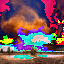

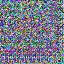

4
[lr: 0.001] [Epoch 1/50] [iter 801/4772] [C_M w-dist: 11.1652] [C_S w-dist: 4.0249] [G loss: -1.9225]


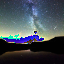

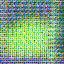

8
12
[lr: 0.001] [Epoch 2/50] [iter 401/4772] [C_M w-dist: 10.9904] [C_S w-dist: 4.1822] [G loss: -1.6563]


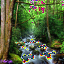

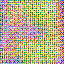

16
[lr: 0.001] [Epoch 2/50] [iter 801/4772] [C_M w-dist: 10.6606] [C_S w-dist: 10.9284] [G loss: -2.3667]


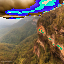

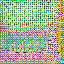

20
24
[lr: 0.001] [Epoch 3/50] [iter 401/4772] [C_M w-dist: 10.9413] [C_S w-dist: 9.5126] [G loss: -1.9929]


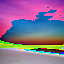

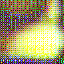

[lr: 0.001] [Epoch 3/50] [iter 801/4772] [C_M w-dist: 10.8827] [C_S w-dist: 8.1494] [G loss: -2.3210]


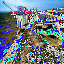

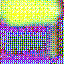

[lr: 0.001] [Epoch 4/50] [iter 101/4772] [C_M w-dist: 10.9096] [C_S w-dist: 4.4952] [G loss: -2.4637]
[lr: 0.001] [Epoch 4/50] [iter 201/4772] [C_M w-dist: 10.9187] [C_S w-dist: 8.8191] [G loss: -2.0663]
[lr: 0.001] [Epoch 4/50] [iter 301/4772] [C_M w-dist: 10.9477] [C_S w-dist: 2.5814] [G loss: -2.4402]
[lr: 0.001] [Epoch 4/50] [iter 401/4772] [C_M w-dist: 10.9441] [C_S w-dist: 1.9948] [G loss: -2.4132]


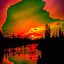

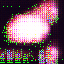

[lr: 0.001] [Epoch 4/50] [iter 501/4772] [C_M w-dist: 10.9641] [C_S w-dist: 10.4967] [G loss: -2.0406]
[lr: 0.001] [Epoch 4/50] [iter 601/4772] [C_M w-dist: 11.0105] [C_S w-dist: 10.7370] [G loss: -2.4438]
[lr: 0.001] [Epoch 4/50] [iter 701/4772] [C_M w-dist: 10.9741] [C_S w-dist: 10.2243] [G loss: -2.5960]
[lr: 0.001] [Epoch 4/50] [iter 801/4772] [C_M w-dist: 10.9903] [C_S w-dist: 9.3498] [G loss: -2.4762]


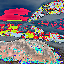

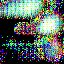

[lr: 0.001] [Epoch 4/50] [iter 901/4772] [C_M w-dist: 11.0263] [C_S w-dist: 6.8598] [G loss: -2.3015]
[lr: 0.001] [Epoch 4/50] [iter 1001/4772] [C_M w-dist: 11.0203] [C_S w-dist: 9.6093] [G loss: -2.3684]
[lr: 0.001] [Epoch 4/50] [iter 1101/4772] [C_M w-dist: 11.0281] [C_S w-dist: 8.6823] [G loss: -2.2518]
[lr: 0.001] [Epoch 5/50] [iter 101/4772] [C_M w-dist: 10.9665] [C_S w-dist: 9.1612] [G loss: -2.4796]
[lr: 0.001] [Epoch 5/50] [iter 201/4772] [C_M w-dist: 10.9549] [C_S w-dist: 8.6138] [G loss: -2.6164]
[lr: 0.001] [Epoch 5/50] [iter 301/4772] [C_M w-dist: 10.9557] [C_S w-dist: 8.1826] [G loss: -2.5747]
[lr: 0.001] [Epoch 5/50] [iter 401/4772] [C_M w-dist: 10.9983] [C_S w-dist: 4.2782] [G loss: -2.0647]


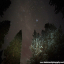

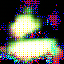

[lr: 0.001] [Epoch 5/50] [iter 501/4772] [C_M w-dist: 10.9180] [C_S w-dist: 4.3675] [G loss: -2.6997]
[lr: 0.001] [Epoch 5/50] [iter 601/4772] [C_M w-dist: 10.9183] [C_S w-dist: 10.5779] [G loss: -2.1077]
[lr: 0.001] [Epoch 5/50] [iter 701/4772] [C_M w-dist: 10.9935] [C_S w-dist: 8.5279] [G loss: -2.2015]
[lr: 0.001] [Epoch 5/50] [iter 801/4772] [C_M w-dist: 10.9644] [C_S w-dist: 10.3696] [G loss: -2.2991]


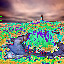

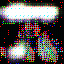

[lr: 0.001] [Epoch 5/50] [iter 901/4772] [C_M w-dist: 10.9698] [C_S w-dist: 9.0957] [G loss: -2.5553]
[lr: 0.001] [Epoch 5/50] [iter 1001/4772] [C_M w-dist: 10.9353] [C_S w-dist: 9.0314] [G loss: -2.3902]
[lr: 0.001] [Epoch 5/50] [iter 1101/4772] [C_M w-dist: 10.9830] [C_S w-dist: 9.4714] [G loss: -2.5193]
500
[lr: 0.001] [Epoch 6/50] [iter 101/4772] [C_M w-dist: 10.9628] [C_S w-dist: 9.3473] [G loss: -2.3217]
[lr: 0.001] [Epoch 6/50] [iter 201/4772] [C_M w-dist: 10.9046] [C_S w-dist: 10.6436] [G loss: -2.4363]
[lr: 0.001] [Epoch 6/50] [iter 301/4772] [C_M w-dist: 10.9234] [C_S w-dist: 8.6067] [G loss: -2.1064]
[lr: 0.001] [Epoch 6/50] [iter 401/4772] [C_M w-dist: 10.9072] [C_S w-dist: 9.3250] [G loss: -2.6112]


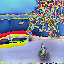

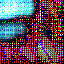

[lr: 0.001] [Epoch 6/50] [iter 501/4772] [C_M w-dist: 10.9837] [C_S w-dist: 9.5502] [G loss: -2.2705]
[lr: 0.001] [Epoch 6/50] [iter 601/4772] [C_M w-dist: 10.9300] [C_S w-dist: 8.2406] [G loss: -2.3797]
[lr: 0.001] [Epoch 6/50] [iter 701/4772] [C_M w-dist: 10.9308] [C_S w-dist: 8.8147] [G loss: -2.2445]
[lr: 0.001] [Epoch 6/50] [iter 801/4772] [C_M w-dist: 10.9928] [C_S w-dist: 1.6141] [G loss: -2.4284]


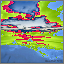

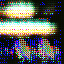

[lr: 0.001] [Epoch 6/50] [iter 901/4772] [C_M w-dist: 10.9814] [C_S w-dist: 8.3944] [G loss: -2.2917]
[lr: 0.001] [Epoch 6/50] [iter 1001/4772] [C_M w-dist: 10.9616] [C_S w-dist: 8.2743] [G loss: -2.2889]
[lr: 0.001] [Epoch 6/50] [iter 1101/4772] [C_M w-dist: 10.9597] [C_S w-dist: 7.3580] [G loss: -2.4166]
[lr: 0.001] [Epoch 7/50] [iter 101/4772] [C_M w-dist: 10.9108] [C_S w-dist: 9.5091] [G loss: -2.2675]
[lr: 0.001] [Epoch 7/50] [iter 201/4772] [C_M w-dist: 10.9320] [C_S w-dist: 6.2804] [G loss: -2.5365]
[lr: 0.001] [Epoch 7/50] [iter 301/4772] [C_M w-dist: 10.9305] [C_S w-dist: 6.1013] [G loss: -2.5491]
[lr: 0.001] [Epoch 7/50] [iter 401/4772] [C_M w-dist: 10.9989] [C_S w-dist: 9.8532] [G loss: -2.5991]


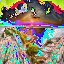

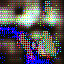

[lr: 0.001] [Epoch 7/50] [iter 501/4772] [C_M w-dist: 10.9306] [C_S w-dist: 7.8967] [G loss: -2.2228]
[lr: 0.001] [Epoch 7/50] [iter 601/4772] [C_M w-dist: 10.9724] [C_S w-dist: 8.6066] [G loss: -2.4268]
[lr: 0.001] [Epoch 7/50] [iter 701/4772] [C_M w-dist: 10.9864] [C_S w-dist: 10.5500] [G loss: -2.3866]
[lr: 0.001] [Epoch 7/50] [iter 801/4772] [C_M w-dist: 10.9387] [C_S w-dist: 8.2374] [G loss: -2.6167]


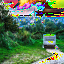

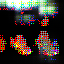

[lr: 0.001] [Epoch 7/50] [iter 901/4772] [C_M w-dist: 10.9642] [C_S w-dist: 5.9128] [G loss: -2.5605]
[lr: 0.001] [Epoch 7/50] [iter 1001/4772] [C_M w-dist: 10.9355] [C_S w-dist: 3.5244] [G loss: -2.5722]
[lr: 0.001] [Epoch 7/50] [iter 1101/4772] [C_M w-dist: 10.9553] [C_S w-dist: 9.4232] [G loss: -2.4688]
1000
[lr: 0.001] [Epoch 9/50] [iter 101/4772] [C_M w-dist: 10.9978] [C_S w-dist: 9.5558] [G loss: -2.3571]
[lr: 0.001] [Epoch 9/50] [iter 201/4772] [C_M w-dist: 10.9967] [C_S w-dist: 7.4636] [G loss: -2.3731]
[lr: 0.001] [Epoch 9/50] [iter 301/4772] [C_M w-dist: 10.9670] [C_S w-dist: 9.3878] [G loss: -2.5555]
[lr: 0.001] [Epoch 9/50] [iter 401/4772] [C_M w-dist: 10.9835] [C_S w-dist: 8.1487] [G loss: -2.3458]


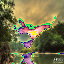

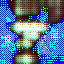

[lr: 0.001] [Epoch 9/50] [iter 501/4772] [C_M w-dist: 10.9395] [C_S w-dist: 4.7514] [G loss: -2.3847]
[lr: 0.001] [Epoch 9/50] [iter 601/4772] [C_M w-dist: 10.9911] [C_S w-dist: 6.0497] [G loss: -2.4223]
[lr: 0.001] [Epoch 9/50] [iter 701/4772] [C_M w-dist: 10.9738] [C_S w-dist: 8.3209] [G loss: -2.5594]
[lr: 0.001] [Epoch 9/50] [iter 801/4772] [C_M w-dist: 10.9795] [C_S w-dist: 5.0717] [G loss: -2.8256]


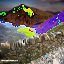

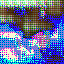

[lr: 0.001] [Epoch 9/50] [iter 901/4772] [C_M w-dist: 10.9933] [C_S w-dist: 8.7933] [G loss: -2.4197]
[lr: 0.001] [Epoch 9/50] [iter 1001/4772] [C_M w-dist: 10.9007] [C_S w-dist: 10.4411] [G loss: -2.8947]
[lr: 0.001] [Epoch 9/50] [iter 1101/4772] [C_M w-dist: 10.9263] [C_S w-dist: 8.9769] [G loss: -2.3141]
[lr: 0.001] [Epoch 10/50] [iter 101/4772] [C_M w-dist: 10.9905] [C_S w-dist: 5.1783] [G loss: -2.2943]
[lr: 0.001] [Epoch 10/50] [iter 201/4772] [C_M w-dist: 10.9630] [C_S w-dist: 6.1411] [G loss: -2.7599]
[lr: 0.001] [Epoch 10/50] [iter 301/4772] [C_M w-dist: 11.0279] [C_S w-dist: 3.4714] [G loss: -2.4170]
[lr: 0.001] [Epoch 10/50] [iter 401/4772] [C_M w-dist: 10.9191] [C_S w-dist: 9.8424] [G loss: -2.6488]


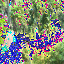

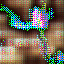

[lr: 0.001] [Epoch 10/50] [iter 501/4772] [C_M w-dist: 10.9362] [C_S w-dist: 9.9986] [G loss: -2.5852]
[lr: 0.001] [Epoch 10/50] [iter 601/4772] [C_M w-dist: 10.9750] [C_S w-dist: 4.4701] [G loss: -2.1982]
[lr: 0.001] [Epoch 10/50] [iter 701/4772] [C_M w-dist: 10.9786] [C_S w-dist: 6.1504] [G loss: -2.5655]
[lr: 0.001] [Epoch 10/50] [iter 801/4772] [C_M w-dist: 10.9112] [C_S w-dist: 7.1526] [G loss: -2.4270]


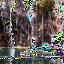

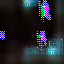

[lr: 0.001] [Epoch 10/50] [iter 901/4772] [C_M w-dist: 10.9621] [C_S w-dist: 2.6217] [G loss: -2.4891]
[lr: 0.001] [Epoch 10/50] [iter 1001/4772] [C_M w-dist: 10.9165] [C_S w-dist: 8.2272] [G loss: -1.8695]
[lr: 0.001] [Epoch 10/50] [iter 1101/4772] [C_M w-dist: 10.9525] [C_S w-dist: 9.4137] [G loss: -2.1060]
1500
[lr: 0.001] [Epoch 12/50] [iter 101/4772] [C_M w-dist: 10.8941] [C_S w-dist: 10.0000] [G loss: -2.3436]
[lr: 0.001] [Epoch 12/50] [iter 201/4772] [C_M w-dist: 10.9610] [C_S w-dist: 7.6395] [G loss: -2.5447]
[lr: 0.001] [Epoch 12/50] [iter 301/4772] [C_M w-dist: 10.9423] [C_S w-dist: 9.0030] [G loss: -2.1239]
[lr: 0.001] [Epoch 12/50] [iter 401/4772] [C_M w-dist: 10.9569] [C_S w-dist: 8.6479] [G loss: -2.2793]


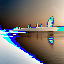

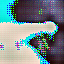

[lr: 0.001] [Epoch 12/50] [iter 501/4772] [C_M w-dist: 10.9607] [C_S w-dist: 3.4879] [G loss: -2.6971]
[lr: 0.001] [Epoch 12/50] [iter 601/4772] [C_M w-dist: 10.9454] [C_S w-dist: 5.2131] [G loss: -2.4182]
[lr: 0.001] [Epoch 12/50] [iter 701/4772] [C_M w-dist: 10.9410] [C_S w-dist: 2.5874] [G loss: -2.0815]
[lr: 0.001] [Epoch 12/50] [iter 801/4772] [C_M w-dist: 10.9522] [C_S w-dist: 8.4233] [G loss: -2.3461]


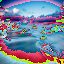

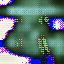

[lr: 0.001] [Epoch 12/50] [iter 901/4772] [C_M w-dist: 10.9221] [C_S w-dist: 7.6711] [G loss: -2.8354]
[lr: 0.001] [Epoch 12/50] [iter 1001/4772] [C_M w-dist: 10.9505] [C_S w-dist: 6.0446] [G loss: -2.5071]
[lr: 0.001] [Epoch 12/50] [iter 1101/4772] [C_M w-dist: 10.9331] [C_S w-dist: 7.9086] [G loss: -2.7796]
[lr: 0.001] [Epoch 13/50] [iter 101/4772] [C_M w-dist: 10.9557] [C_S w-dist: 8.9888] [G loss: -2.5575]
[lr: 0.001] [Epoch 13/50] [iter 201/4772] [C_M w-dist: 10.9536] [C_S w-dist: 8.1201] [G loss: -2.7286]
[lr: 0.001] [Epoch 13/50] [iter 301/4772] [C_M w-dist: 10.9980] [C_S w-dist: 4.7703] [G loss: -2.4976]
[lr: 0.001] [Epoch 13/50] [iter 401/4772] [C_M w-dist: 10.9917] [C_S w-dist: 1.5413] [G loss: -2.7274]


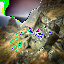

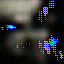

[lr: 0.001] [Epoch 13/50] [iter 501/4772] [C_M w-dist: 11.0610] [C_S w-dist: 3.9704] [G loss: -2.6828]
[lr: 0.001] [Epoch 13/50] [iter 601/4772] [C_M w-dist: 11.0070] [C_S w-dist: 9.0525] [G loss: -2.5280]
[lr: 0.001] [Epoch 13/50] [iter 701/4772] [C_M w-dist: 10.9928] [C_S w-dist: 5.8557] [G loss: -2.2734]
[lr: 0.001] [Epoch 13/50] [iter 801/4772] [C_M w-dist: 10.9683] [C_S w-dist: 5.0659] [G loss: -2.4981]


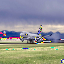

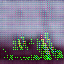

[lr: 0.001] [Epoch 13/50] [iter 901/4772] [C_M w-dist: 10.8673] [C_S w-dist: 10.9402] [G loss: -2.3614]
[lr: 0.001] [Epoch 13/50] [iter 1001/4772] [C_M w-dist: 10.7732] [C_S w-dist: 10.7838] [G loss: -2.5659]
[lr: 0.001] [Epoch 13/50] [iter 1101/4772] [C_M w-dist: 10.7811] [C_S w-dist: 9.7317] [G loss: -2.6274]
2000
[lr: 0.001] [Epoch 15/50] [iter 101/4772] [C_M w-dist: 11.0017] [C_S w-dist: 7.6646] [G loss: -2.2121]
[lr: 0.001] [Epoch 15/50] [iter 201/4772] [C_M w-dist: 10.8936] [C_S w-dist: 9.2498] [G loss: -2.7427]
[lr: 0.001] [Epoch 15/50] [iter 301/4772] [C_M w-dist: 11.0287] [C_S w-dist: 9.3517] [G loss: -2.6495]
[lr: 0.001] [Epoch 15/50] [iter 401/4772] [C_M w-dist: 10.9746] [C_S w-dist: 4.6889] [G loss: -2.5975]


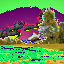

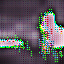

[lr: 0.001] [Epoch 15/50] [iter 501/4772] [C_M w-dist: 11.0095] [C_S w-dist: 3.5751] [G loss: -2.4856]
[lr: 0.001] [Epoch 15/50] [iter 601/4772] [C_M w-dist: 11.0064] [C_S w-dist: 9.8682] [G loss: -2.4252]
[lr: 0.001] [Epoch 15/50] [iter 701/4772] [C_M w-dist: 10.9488] [C_S w-dist: 10.4310] [G loss: -1.9102]
[lr: 0.001] [Epoch 15/50] [iter 801/4772] [C_M w-dist: 10.9607] [C_S w-dist: 10.3877] [G loss: -2.6199]


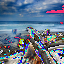

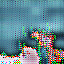

[lr: 0.001] [Epoch 15/50] [iter 901/4772] [C_M w-dist: 10.9516] [C_S w-dist: 8.8539] [G loss: -2.6650]
[lr: 0.001] [Epoch 15/50] [iter 1001/4772] [C_M w-dist: 10.9579] [C_S w-dist: 8.4190] [G loss: -2.5621]
[lr: 0.001] [Epoch 15/50] [iter 1101/4772] [C_M w-dist: 11.0598] [C_S w-dist: 9.6492] [G loss: -2.6636]
[lr: 0.001] [Epoch 16/50] [iter 101/4772] [C_M w-dist: 10.9158] [C_S w-dist: 10.1744] [G loss: -2.0764]
[lr: 0.001] [Epoch 16/50] [iter 201/4772] [C_M w-dist: 10.9456] [C_S w-dist: 10.3436] [G loss: -2.6346]
[lr: 0.001] [Epoch 16/50] [iter 301/4772] [C_M w-dist: 10.9319] [C_S w-dist: 10.6164] [G loss: -2.7422]
[lr: 0.001] [Epoch 16/50] [iter 401/4772] [C_M w-dist: 10.9446] [C_S w-dist: 8.8209] [G loss: -2.2668]


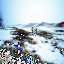

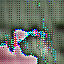

[lr: 0.001] [Epoch 16/50] [iter 501/4772] [C_M w-dist: 11.0215] [C_S w-dist: 9.6709] [G loss: -2.4492]
[lr: 0.001] [Epoch 16/50] [iter 601/4772] [C_M w-dist: 10.9543] [C_S w-dist: 9.6114] [G loss: -2.1686]
[lr: 0.001] [Epoch 16/50] [iter 701/4772] [C_M w-dist: 10.9104] [C_S w-dist: 10.6706] [G loss: -2.0802]
[lr: 0.001] [Epoch 16/50] [iter 801/4772] [C_M w-dist: 10.9100] [C_S w-dist: 10.7218] [G loss: -2.3975]


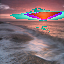

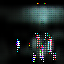

[lr: 0.001] [Epoch 16/50] [iter 901/4772] [C_M w-dist: 10.9062] [C_S w-dist: 10.4690] [G loss: -2.5903]
[lr: 0.001] [Epoch 16/50] [iter 1001/4772] [C_M w-dist: 10.8462] [C_S w-dist: 10.6517] [G loss: -2.6180]
[lr: 0.001] [Epoch 16/50] [iter 1101/4772] [C_M w-dist: 10.9585] [C_S w-dist: 10.2776] [G loss: -2.0924]
2500
[lr: 0.001] [Epoch 18/50] [iter 101/4772] [C_M w-dist: 10.9429] [C_S w-dist: 8.5556] [G loss: -2.6611]
[lr: 0.001] [Epoch 18/50] [iter 201/4772] [C_M w-dist: 10.9666] [C_S w-dist: 5.3091] [G loss: -2.6966]
[lr: 0.001] [Epoch 18/50] [iter 301/4772] [C_M w-dist: 11.0005] [C_S w-dist: 9.4067] [G loss: -2.2646]
[lr: 0.001] [Epoch 18/50] [iter 401/4772] [C_M w-dist: 10.9272] [C_S w-dist: 7.6531] [G loss: -2.6068]


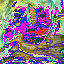

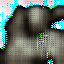

[lr: 0.001] [Epoch 18/50] [iter 501/4772] [C_M w-dist: 10.9698] [C_S w-dist: 9.6417] [G loss: -2.5148]
[lr: 0.001] [Epoch 18/50] [iter 601/4772] [C_M w-dist: 10.9995] [C_S w-dist: 6.4976] [G loss: -2.3259]
[lr: 0.001] [Epoch 18/50] [iter 701/4772] [C_M w-dist: 10.9398] [C_S w-dist: 4.9828] [G loss: -2.4870]
[lr: 0.001] [Epoch 18/50] [iter 801/4772] [C_M w-dist: 10.9623] [C_S w-dist: 4.8994] [G loss: -2.5594]


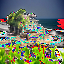

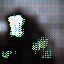

[lr: 0.001] [Epoch 18/50] [iter 901/4772] [C_M w-dist: 10.9393] [C_S w-dist: 4.9801] [G loss: -2.5232]
[lr: 0.001] [Epoch 18/50] [iter 1001/4772] [C_M w-dist: 10.9483] [C_S w-dist: 7.3988] [G loss: -2.4800]
[lr: 0.001] [Epoch 18/50] [iter 1101/4772] [C_M w-dist: 10.8989] [C_S w-dist: 2.7502] [G loss: -2.4676]
[lr: 0.001] [Epoch 19/50] [iter 101/4772] [C_M w-dist: 10.8719] [C_S w-dist: 9.4022] [G loss: -2.3443]
[lr: 0.001] [Epoch 19/50] [iter 201/4772] [C_M w-dist: 10.9090] [C_S w-dist: 7.0615] [G loss: -2.5145]
[lr: 0.001] [Epoch 19/50] [iter 301/4772] [C_M w-dist: 10.9698] [C_S w-dist: 6.6837] [G loss: -2.3608]
[lr: 0.001] [Epoch 19/50] [iter 401/4772] [C_M w-dist: 10.9177] [C_S w-dist: 9.8885] [G loss: -2.3923]


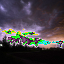

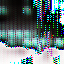

[lr: 0.001] [Epoch 19/50] [iter 501/4772] [C_M w-dist: 10.9739] [C_S w-dist: 3.2368] [G loss: -2.4651]
[lr: 0.001] [Epoch 19/50] [iter 601/4772] [C_M w-dist: 10.9380] [C_S w-dist: 9.1162] [G loss: -2.5646]
[lr: 0.001] [Epoch 19/50] [iter 701/4772] [C_M w-dist: 10.9661] [C_S w-dist: 9.6170] [G loss: -2.6284]
[lr: 0.001] [Epoch 19/50] [iter 801/4772] [C_M w-dist: 10.8271] [C_S w-dist: 10.3438] [G loss: -2.4186]


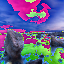

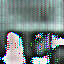

[lr: 0.001] [Epoch 19/50] [iter 901/4772] [C_M w-dist: 10.9439] [C_S w-dist: 10.6939] [G loss: -2.3053]
[lr: 0.001] [Epoch 19/50] [iter 1001/4772] [C_M w-dist: 10.9390] [C_S w-dist: 7.9573] [G loss: -2.6549]
[lr: 0.001] [Epoch 19/50] [iter 1101/4772] [C_M w-dist: 10.9473] [C_S w-dist: 6.3861] [G loss: -2.6874]
3000
[lr: 0.001] [Epoch 21/50] [iter 101/4772] [C_M w-dist: 10.5006] [C_S w-dist: 10.9679] [G loss: -3.0504]
[lr: 0.001] [Epoch 21/50] [iter 201/4772] [C_M w-dist: 10.4188] [C_S w-dist: 10.8945] [G loss: -3.3483]
[lr: 0.001] [Epoch 21/50] [iter 301/4772] [C_M w-dist: 10.6393] [C_S w-dist: 10.8238] [G loss: -2.6599]
[lr: 0.001] [Epoch 21/50] [iter 401/4772] [C_M w-dist: 10.8191] [C_S w-dist: 10.3441] [G loss: -2.4884]


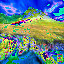

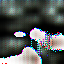

[lr: 0.001] [Epoch 21/50] [iter 501/4772] [C_M w-dist: 10.9380] [C_S w-dist: 9.4930] [G loss: -2.1578]
[lr: 0.001] [Epoch 21/50] [iter 601/4772] [C_M w-dist: 10.9090] [C_S w-dist: 8.9558] [G loss: -2.4992]
[lr: 0.001] [Epoch 21/50] [iter 701/4772] [C_M w-dist: 10.9390] [C_S w-dist: 9.0165] [G loss: -2.5521]
[lr: 0.001] [Epoch 21/50] [iter 801/4772] [C_M w-dist: 10.9054] [C_S w-dist: 9.3568] [G loss: -2.6251]


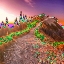

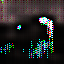

[lr: 0.001] [Epoch 21/50] [iter 901/4772] [C_M w-dist: 10.9116] [C_S w-dist: 9.7505] [G loss: -2.6428]
[lr: 0.001] [Epoch 21/50] [iter 1001/4772] [C_M w-dist: 10.9070] [C_S w-dist: 5.6279] [G loss: -2.7311]
[lr: 0.001] [Epoch 21/50] [iter 1101/4772] [C_M w-dist: 10.9451] [C_S w-dist: 3.8995] [G loss: -2.6855]
[lr: 0.001] [Epoch 22/50] [iter 101/4772] [C_M w-dist: 10.9205] [C_S w-dist: 6.9439] [G loss: -2.5379]
[lr: 0.001] [Epoch 22/50] [iter 201/4772] [C_M w-dist: 10.9051] [C_S w-dist: 9.6798] [G loss: -2.3804]
[lr: 0.001] [Epoch 22/50] [iter 301/4772] [C_M w-dist: 10.8987] [C_S w-dist: 8.6665] [G loss: -2.9660]
[lr: 0.001] [Epoch 22/50] [iter 401/4772] [C_M w-dist: 10.9580] [C_S w-dist: 7.1067] [G loss: -2.6031]


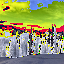

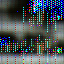

[lr: 0.001] [Epoch 22/50] [iter 501/4772] [C_M w-dist: 10.9892] [C_S w-dist: 7.9922] [G loss: -2.3495]
[lr: 0.001] [Epoch 22/50] [iter 601/4772] [C_M w-dist: 10.9435] [C_S w-dist: 10.3913] [G loss: -2.6631]
[lr: 0.001] [Epoch 22/50] [iter 701/4772] [C_M w-dist: 10.9017] [C_S w-dist: 6.8890] [G loss: -2.6587]
[lr: 0.001] [Epoch 22/50] [iter 801/4772] [C_M w-dist: 10.8702] [C_S w-dist: 7.6041] [G loss: -2.3430]


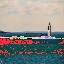

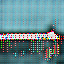

[lr: 0.001] [Epoch 22/50] [iter 901/4772] [C_M w-dist: 10.9578] [C_S w-dist: 4.2554] [G loss: -2.3868]
[lr: 0.001] [Epoch 22/50] [iter 1001/4772] [C_M w-dist: 10.9328] [C_S w-dist: 4.0289] [G loss: -2.5882]
[lr: 0.001] [Epoch 22/50] [iter 1101/4772] [C_M w-dist: 10.9856] [C_S w-dist: 9.3029] [G loss: -2.5027]
3500
[lr: 0.001] [Epoch 24/50] [iter 101/4772] [C_M w-dist: 11.0250] [C_S w-dist: 5.8519] [G loss: -2.5689]
[lr: 0.001] [Epoch 24/50] [iter 201/4772] [C_M w-dist: 11.0049] [C_S w-dist: 8.4100] [G loss: -2.4372]
[lr: 0.001] [Epoch 24/50] [iter 301/4772] [C_M w-dist: 10.9166] [C_S w-dist: 6.2253] [G loss: -2.7017]
[lr: 0.001] [Epoch 24/50] [iter 401/4772] [C_M w-dist: 10.9827] [C_S w-dist: 8.0017] [G loss: -2.7058]


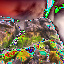

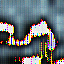

[lr: 0.001] [Epoch 24/50] [iter 501/4772] [C_M w-dist: 10.9699] [C_S w-dist: 8.9101] [G loss: -2.7287]
[lr: 0.001] [Epoch 24/50] [iter 601/4772] [C_M w-dist: 10.9456] [C_S w-dist: 10.1123] [G loss: -2.6385]
[lr: 0.001] [Epoch 24/50] [iter 701/4772] [C_M w-dist: 11.0036] [C_S w-dist: 10.4850] [G loss: -2.3542]


KeyboardInterrupt: ignored

In [14]:
def run_training_loop_GAN(batch_size, lr, epochs, lambda_cyc, base_filter_size=64, lambda_grad_pen=10):
  # Loss is L_Gan1 + L_Gan2 + lambda * Loss_cyc(G, F)
  # Initialize networks
  gen_S2M = Generator().to(device) # Generates images from scenery to monet
  critic_M = Critic().to(device)   # Critic to determine real or fake monet

  gen_M2S = Generator().to(device) # Generates images from monet to scenery
  critic_S = Critic().to(device)   # Critic to determine real or fake scenery

  # Initialize optimizers:
  gen_optim = torch.optim.Adam(list(gen_S2M.parameters()) + list(gen_M2S.parameters()), lr=lr, betas=(0.9, 0.999))

  crit_optim_M = torch.optim.Adam(critic_M.parameters(), lr=lr, betas=(0.9, 0.999))
  crit_optim_S = torch.optim.Adam(critic_M.parameters(), lr=lr, betas=(0.9, 0.999))

  # Initialize DataLoaders:
  monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
  scene_loader = DataLoader(scene_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

  # Initialize Losses:
  Cyc_Loss = nn.L1Loss()

  # True images have a target of 
  #one = torch.FloatTensor([1]).to(device)
  #minus_one = torch.FloatTensor([-1]).to(device)
  #zero_tensor = torch.FloatTensor([0]).to(device)

  image_list = []
  G_losses = []
  C_S_losses = []
  C_M_losses = []
  gen_iter = 0
  clipping_threshold = 0.01


  for epoch in range(epochs):
    monet_iter = iter(monet_loader)
    scene_iter = iter(scene_loader)

    i = 0
    n_critic = 5
    while i < len(monet_loader):
      # Ensure critic has requires_grad (I turn it off later when training gen)
      for param in critic_M.parameters():
        param.requires_grad = True
      for param in critic_S.parameters():
        param.requires_grad = True

      # Train critic more for the start and every 500 iters to improve stability
      if gen_iter < 100 or gen_iter % 500 == 0:
        n_critic = 100

      # Get input data:
      real_monet_batch = next(monet_iter)
      for real_monet in real_monet_batch:
        real_monet = real_monet.to(device)
        real_scene = next(scene_iter).to(device)
        batch_size = real_scene.size(0) # Ensures correct batching

        # ******************************
        # Train Critics:
        # ******************************
        critic_iter = 0
        while critic_iter < n_critic and i < len(monet_loader):
          critic_iter += 1
          i += 1
          for param in critic_M.parameters():
            param.data.clamp_(-clipping_threshold, clipping_threshold)
          for param in critic_S.parameters():
            param.data.clamp_(-clipping_threshold, clipping_threshold)

          # -------------------------------------------
          # Train Critic from Monet to Scenery:
          # -------------------------------------------
          # Train with real monet images:
          critic_S.zero_grad()
          critic_real_monet = critic_M(real_monet).mean()

          # Train with fake monet images
          fake_monet = gen_S2M(real_scene)
          critic_fake_monet = critic_M(fake_monet).mean()

          w_dist_M = critic_real_monet + critic_fake_monet + lambda_grad_pen * gradient_penalty(critic_S, real_monet, fake_monet)
          C_M_losses.append(w_dist_M)
          w_dist_M.backward()
          # Critic Update:
          crit_optim_M.step()

          # -------------------------------------------
          # Train Critic from Monet to Scenery:
          # -------------------------------------------
          # Train with real monet images:
          critic_M.zero_grad()
          critic_real_scene = critic_S(real_scene).mean()

          # Train with fake monet images
          fake_scene = gen_M2S(real_monet)
          critic_fake_scene = critic_S(fake_scene).mean()

          w_dist_S = critic_real_scene + critic_fake_scene + lambda_grad_pen * gradient_penalty(critic_M, real_scene, fake_scene)
          w_dist_S.backward()
          # Critic Update:
          crit_optim_S.step()

        # ******************************
        # Train Generators:
        # ******************************
        for param in critic_M.parameters():
          param.requires_grad = False
        for param in critic_S.parameters():
          param.requires_grad = False
        gen_optim.zero_grad()

        # Monet Gen:
        critic_real_monet_2 = critic_M(real_monet)
        fake_monet_2 = gen_S2M(real_scene)
        critic_fake_monet_2 = critic_M(fake_monet_2)

        # Scene Gen:
        critic_real_scene_2 = critic_M(real_scene)
        fake_scene_2 = gen_M2S(real_monet)
        critic_fake_scene_2 = critic_S(fake_scene_2)

        # Full Objective Function
        L_GAN_M = torch.mean(torch.log(critic_real_monet_2 + 1e-9)) + torch.mean(torch.log(1 - critic_fake_monet_2 + 1e-9))
        L_GAN_S = torch.mean(torch.log(critic_real_scene_2 + 1e-9)) + torch.mean(torch.log(1 - critic_fake_scene_2 + 1e-9))
        L_Cyc = Cyc_Loss(gen_S2M(fake_scene_2), real_monet) + Cyc_Loss(gen_M2S(fake_monet_2), real_scene)
        loss = L_GAN_M + L_GAN_S + lambda_cyc * L_Cyc
        loss.backward()
        gen_optim.step()

        gen_iter += 1

      # Print out results:
      if i % 100 == 0:
        print(f"[lr: {lr}] " f"[Epoch {epoch+1}/{epochs}] " f"[iter {i+1}/{len(monet_loader)*4}] "
              f"[C_M w-dist: {w_dist_M.item():.4f}] " f"[C_S w-dist: {w_dist_S.item():.4f}] " f"[G loss: {loss.item():.4f}]")

        # Print images for qualitative updates
        if i % 400 == 0:
          # Print real scenery:
          display_fake_real_tensor_image(fake_monet_2, real_scene)
          #transform = transforms.ToPILImage()
          #real_scene = real_scene.squeeze()
          #transform(real_scene).show()
#
          ## Print generated monet:
          #fake_monet_2 = fake_monet_2.squeeze()
          #transform(fake_monet_2).show()

        # Save loss for printing:
        G_losses.append(loss.item())
        C_S_losses.append(w_dist_S.item())
        C_M_losses.append(w_dist_M.item())

  return gen_M2S, gen_S2M

# ------------------------------------------
# Run the training loop:
# ------------------------------------------
gen_M2S, gen_S2M = run_training_loop_GAN(batch_size=1, lr=1e-3, epochs=50, lambda_cyc=5, base_filter_size=64, lambda_grad_pen=10)


In [ ]:
# Added lambda_cyc * LCyc (hopefully will help to improve training)

# Next hyper-parameters to try:
# 1: lr = 0.0002 for 100 epochs then linearly scaling down to 0 for 100 epochs
# 2: n_critic = 200 for start
# 3: Change hyper-parameters related to data augmentation of what monet is (try without it?)

#Testing

In [ ]:
# Plot Loss:

In [20]:
print(mon_ann[0])

00164.jpg


In [21]:
image_filepath = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Monet/" + mon_ann[0]
to_tensor = transforms.Compose([transforms.ToTensor()])
img = Image.open(image_filepath)
if (img.mode != "RGB"):
  img = img.convert('RGB')
img_monet = img.resize((64,64), Image.BOX)

gen_M2S.to('cpu')
fake_scene = gen_M2S(img_monet)
display_fake_real_tensor_image(fake_scene, img_monet)

NameError: ignored

In [ ]:
image_filepath = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Photos/" + scene_ann[len(scene_ann) - 1]
to_tensor = transforms.Compose([transforms.ToTensor()])
img = Image.open(image_filepath)
if (img.mode != "RGB"):
  img = img.convert('RGB')
img_scene = img.resize((64,64), Image.BOX)

gen_S2M.to('cpu')
fake_monet = gen_S2M(img_scene)
display_fake_real_tensor_image(fake_monet, img_scene)